In [3]:
import os.path
import numpy as np
import pandas as pd
import time
from datetime import datetime

import shtReader_py.shtRipper as shtRipper
from source.Files_operating import read_dataFile
from source.NN_environment import process_fragments, get_borders, normalise_series, down_to_zero
from source.NN_environment import get_prediction_unet

---
# Processing system
---

In [12]:
interval_path = "data/intervals/"
signal_path = "data/d-alpha/"

filename = "sht44168"
F_ID = filename[-5:]

df = pd.read_csv(signal_path + filename + ".txt", sep=',')  # read_dataFile(interval_path + filename + "_exportGlobus2.dat", F_ID)
df = df.rename(columns={"D-alpha_h50": "ch1"})
df["ch1_marked"] = 0
df["ch1_ai_marked"] = 0

# print(df.head())

start_time = time.time()

ckpt_v=2
df["ch1_ai_marked"] = get_prediction_unet(df["ch1"].to_numpy(), ckpt_v=ckpt_v)  # , old=True

df["ch1_marked"] = down_to_zero(np.array(df["ch1_ai_marked"]), edge=0.5)
df["ch1_marked"] = process_fragments(np.array(df["ch1"]), np.array(df["ch1_marked"]), length_edge=20, scale=0)

to_pack = {
    "D-alpha, chord=50 cm": {
        'comment': f'SHOT: #{F_ID}',
        'unit': 'U(V)',
        'tMin': df.t.min(),  # minimum time
        'tMax': df.t.max(),  # maximum time
        'offset': 0.0,  # ADC zero level offset
        'yRes': -0.00255615,  # ADC resolution: 0.0001 Volt per adc bit
        'y': df.ch1.to_list()
    },
    "Mark": {
        'comment': f'ELMs marks (by proc-sys v2.0-0scl; {datetime.now().strftime("%d.%m.%Y")})',
        'unit': 'U(V)',
        'tMin': df.t.min(),  # minimum time
        'tMax': df.t.max(),  # maximum time
        'offset': 0.0,  # ADC zero level offset
        'yRes': 0.0001,  # ADC resolution: 0.0001 Volt per adc bit
        'y': df.ch1_marked.to_list()
    },
    "AI prediction": {
        'comment': f'Processed NN prediction of ELMs (v{ckpt_v}; trn-on: ...)',
        'unit': 'U(V)',
        'tMin': df.t.min(),  # minimum time
        'tMax': df.t.max(),  # maximum time
        'offset': 0.0,  # ADC zero level offset
        'yRes': 0.0001,  # ADC resolution: 0.0001 Volt per adc bit
        'y': df.ch1_ai_marked.to_list()
    },
}

packed = shtRipper.ripper.write(path="D:/Edu/Lab/D-alpha-instability-search/data/sht/marked/", filename=f'{F_ID}_data.SHT', data=to_pack)

print(f"Result saved successfully to D:/Edu/Lab/D-alpha-instability-search/data/sht/marked/{F_ID}_data.SHT")
print(f"Took - {round(time.time() - start_time, 2)} s")

D:\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 52 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Result saved successfully to D:/Edu/Lab/D-alpha-instability-search/data/sht/marked/44168_data.SHT
Took - 129.36 s


---
---

In [2]:
interval_path = "data/intervals/"
signal_path = "data/d-alpha/"

filename = "sht44183"
F_ID = filename[-5:]

if os.path.isfile(interval_path + f"df/{F_ID}_data.csv"):
    df = pd.read_csv(interval_path + f"df/{F_ID}_data.csv", sep=",")
else:
    df = read_dataFile(interval_path + filename + "_exportGlobus2.dat", F_ID)
    df["ch1_marked"] = pd.Series([0] * df.shape[0])
    df["ch1_ai_marked"] = pd.Series([0] * df.shape[0])

df.describe()

,t,ch1,ch1_marked,ch1_ai_marked
count,76243.000000,76243.000000,76243.000000,7.624300e+04
mean,203.119000,0.529203,0.077935,1.001058e-01
std,22.009603,0.160735,0.268071,2.752408e-01
min,164.998000,0.181490,0.000000,2.584950e-17
25%,184.058500,0.396200,0.000000,9.571570e-08
50%,203.119000,0.526570,0.000000,6.554467e-06
75%,222.179500,0.639040,0.000000,1.165128e-03
max,241.240000,1.265300,1.000000,1.000000e+00


In [3]:
# def process_fragments(data: np.array, mark_data: np.array, edge=10, scale=np.exp(1), step_out=10) -> np.array:
#     proc_slice = Slice(0, 0)
#     cur_slice = Slice(0, 1)
#     f_fragment = False
#
#     while cur_slice.r < mark_data.shape[0]:
#         if mark_data[cur_slice.r] == 1.0:
#             if not f_fragment:
#                 f_fragment = True
#         elif f_fragment:
#             if not cur_slice.check_length(edge):
#                 mark_data[cur_slice.l: cur_slice.r] = 0.0
#                 if not proc_slice.is_null():
#                     mark_data[proc_slice.l: proc_slice.r] = 1.0
#                     proc_slice.collapse_borders()
#             elif not proc_slice.collide_slices(cur_slice, edge):
#                 mark_data[proc_slice.l: proc_slice.r] = 1.0
#                 proc_slice.copy(cur_slice)
#
#             f_fragment = False
#             cur_slice.collapse_borders()
#         elif not f_fragment:
#             cur_slice.collapse_borders()
#             if not proc_slice.is_null():
#                 proc_slice.copy(cur_slice)
#
#         cur_slice.step()
#
#     return mark_data

# elif scale:
# mark_data[cur_slice.l: cur_slice.r] = 0.0
# if cur_slice.check_length(edge):
#     borders = get_borders(data[cur_slice.l: cur_slice.r], scale)
#     # print(boards)
#     borders[0] = max(borders[0] + cur_slice.l - step_out, 0)
#     borders[1] = min(borders[1] + cur_slice.l, mark_data.shape[0])

#     mark_data[borders[0]:borders[1]] = 1.0

In [4]:
# from source.NN_environment import process_fragments

df["ch1_marked"] = down_to_zero(np.array(df["ch1_ai_marked"]), edge=0.5)
df["ch1_marked"] = process_fragments(np.array(df["ch1"]), np.array(df["ch1_marked"]), scale=0)
df.describe()

,t,ch1,ch1_marked,ch1_ai_marked
count,76243.000000,76243.000000,76243.000000,7.624300e+04
mean,203.119000,0.529203,0.083365,1.001058e-01
std,22.009603,0.160735,0.276435,2.752408e-01
min,164.998000,0.181490,0.000000,2.584950e-17
25%,184.058500,0.396200,0.000000,9.571570e-08
50%,203.119000,0.526570,0.000000,6.554467e-06
75%,222.179500,0.639040,0.000000,1.165128e-03
max,241.240000,1.265300,1.000000,1.000000e+00


In [5]:
df.to_csv(interval_path + f"df/{F_ID}_data.csv", index=False)


In [40]:
df["ch1_marked"] = df["ch1_ai_marked"]
df["ch1_ai_marked"] = 0

Input marking mode (0 - manual | 1 - semiauto):  1
Input start index [0:393000]:  0


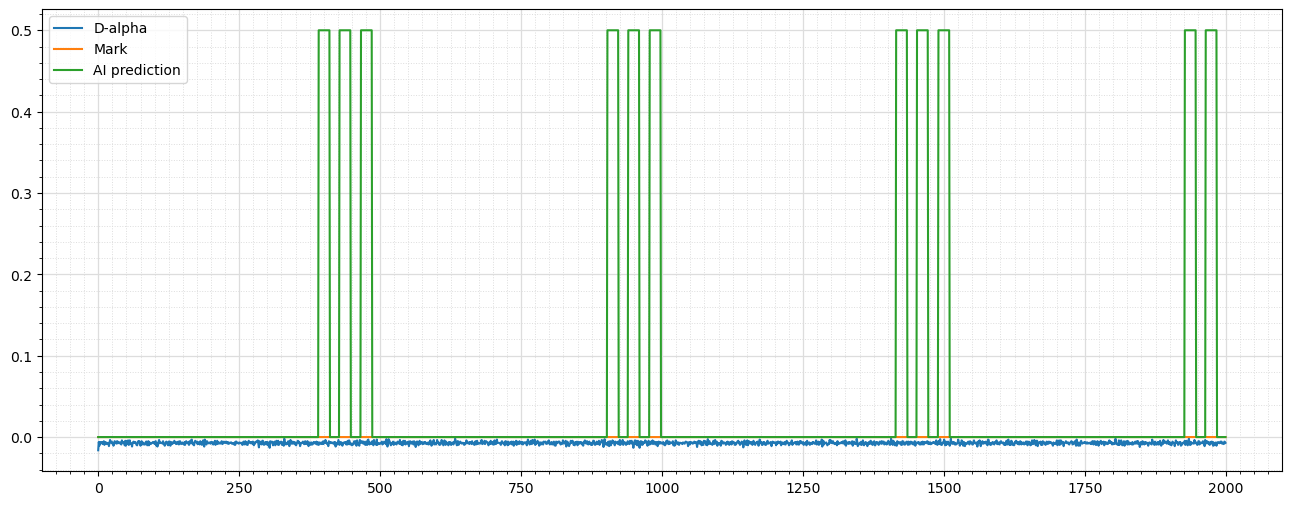

KeyboardInterrupt: Interrupted by user

In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

mode = int(input("Input marking mode (0 - manual | 1 - semiauto): ").strip().split()[0])

l_edge = int(input(f"Input start index [0:{df.shape[0]//1000*1000}]: ").strip().split()[0])
step = 1500
width = 2000

step_away = 10

while l_edge < df.shape[0]:
    fig, ax = plt.subplots()

    fig.set_figwidth(16)
    fig.set_figheight(6)

    r_edge = min(l_edge + width, df.shape[0])

    ax.plot(range(l_edge, r_edge), normalise_series(df.ch1)[l_edge:r_edge], label="D-alpha")
    ax.plot(range(l_edge, r_edge), df.ch1_marked[l_edge:r_edge] * 0.5, label="Mark")
    ax.plot(range(l_edge, r_edge), df.ch1_ai_marked[l_edge:r_edge] * 0.5, label="AI prediction")

    ax.grid(which='major', color='#DDDDDD', linewidth=0.9)
    ax.grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.7)
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    ax.legend()
    plt.show()

    res = list(map(int, input("Input index pairs of ELM fragments:\n").strip().split()))
    for i in range(0, len(res), 2):
        board_ind = [res[i], res[i+1]]
        
        if (df.loc[board_ind[0]:board_ind[1], "ch1_marked"] == 1.).all():
            df.loc[board_ind[0]:board_ind[1], "ch1_marked"] = 0.
        elif (df.loc[board_ind[0]:board_ind[1], "ch1_marked"] == 1.).any():
            if input("Input 1 or 0 to set: ").lower() in ["1", "1.0", "y", "н", "1."]:
                if mode:
                    board_ind = get_borders(df.loc[res[i]:res[i + 1], "ch1"].to_numpy(), scale=1.5)
                    board_ind[0] = max(board_ind[0] - step_away + res[i], 0)
                    board_ind[1] += res[i]
                    
                df.loc[board_ind[0]:board_ind[1], "ch1_marked"] = 1.
            else:
                df.loc[board_ind[0]:board_ind[1], "ch1_marked"] = 0.
        else:
            if mode:
                board_ind = get_borders(df.loc[res[i]:res[i + 1], "ch1"].to_numpy(), scale=1.5)
                board_ind[0] = max(board_ind[0] - step_away + res[i], 0)
                board_ind[1] += res[i]
                
            df.loc[board_ind[0]:board_ind[1], "ch1_marked"] = 1.

    plt.close()
    plt.clf()
    l_edge += step

In [50]:
df.to_csv(f"data/intervals/df/{F_ID}_data.csv", index=False)
df.describe()

,t,ch1,ch1_marked,ch1_ai_marked
count,65970.000000,65970.000000,65970.000000,65970.0
mean,197.454500,0.552893,0.095362,0.0
std,19.044043,0.186984,0.293716,0.0
min,164.470000,0.191710,0.000000,0.0
25%,180.962250,0.401320,0.000000,0.0
50%,197.454500,0.534240,0.000000,0.0
75%,213.946750,0.674820,0.000000,0.0
max,230.439000,1.536200,1.000000,0.0


In [51]:
count = 0
for i in range(df.shape[0]-1):
    if df.iloc[i].ch1_marked == 0 and df.iloc[i+1].ch1_marked == 1:
        count += 1
print(count)

56


---
## AI marking
---

In [4]:
from source.NN_environment import get_prediction_unet

df["ch1_ai_marked"] = get_prediction_unet(df["ch1"].to_numpy(), ckpt_v=2)  # , old=True
df.to_csv(interval_path + f"df/{F_ID}_data.csv", index=False)
df.describe()

D:\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 52 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


,t,ch1,ch1_marked,ch1_ai_marked
count,76243.000000,76243.000000,76243.0,7.624300e+04
mean,203.119000,0.529203,0.0,1.001058e-01
std,22.009603,0.160735,0.0,2.752408e-01
min,164.998000,0.181490,0.0,2.584950e-17
25%,184.058500,0.396200,0.0,9.571570e-08
50%,203.119000,0.526570,0.0,6.554467e-06
75%,222.179500,0.639040,0.0,1.165128e-03
max,241.240000,1.265300,0.0,1.000000e+00


---
## Export to SHT
---

In [7]:
import shtReader_py.shtRipper as shtRipper

to_pack = {
    "D-alpha, chord=50 cm": {
        'comment': f'SHOT: #{F_ID}',
        'unit': 'U(V)',
        'tMin': df.t.min(),  # minimum time
        'tMax': df.t.max(),  # maximum time
        'offset': 0.0,  # ADC zero level offset
        'yRes': -0.00255615,  # ADC resolution: 0.0001 Volt per adc bit
        'y': df.ch1.to_list()
    },
    "Mark": {
        'comment': 'ELMs marks (by proc-sys v2.0-0scl; 31.07.2024)',
        'unit': 'U(V)',
        'tMin': df.t.min(),  # minimum time
        'tMax': df.t.max(),  # maximum time
        'offset': 0.0,  # ADC zero level offset
        'yRes': 0.0001,  # ADC resolution: 0.0001 Volt per adc bit
        'y': df.ch1_marked.to_list()
    },
    "AI prediction": {
        'comment': 'Processed NN prediction of ELMs (v2 new; trn-on: #44184, #44194)',
        'unit': 'U(V)',
        'tMin': df.t.min(),  # minimum time
        'tMax': df.t.max(),  # maximum time
        'offset': 0.0,  # ADC zero level offset
        'yRes': 0.0001,  # ADC resolution: 0.0001 Volt per adc bit
        'y': df.ch1_ai_marked.to_list()
    },
}

packed = shtRipper.ripper.write(path="D:/Edu/Lab/D-alpha-instability-search/data/sht/marked/", filename=f'{F_ID}_data.SHT', data=to_pack)